# Visual Analytics - Text Mining Lord of the Rings Movie Scripts

In [1]:
# Setup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import csv

import re
from PIL import Image

# import nltk
# nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud

### Load Data

In [2]:
# load data - https://www.kaggle.com/paultimothymooney/lord-of-the-rings-data
chars = pd.read_csv('data/lotr_characters.csv')
chars

,birth,death,gender,hair,height,name,race,realm,spouse
0,NaN,NaN,Female,NaN,NaN,Adanel,Men,NaN,Belemir
1,TA 2978,"February 26 ,3019",Male,Dark (book) Light brown (movie),NaN,Boromir,Men,NaN,NaN
2,NaN,"March ,3019",Male,NaN,NaN,Lagduf,Orcs,NaN,NaN
3,TA 280,TA 515,Male,NaN,NaN,Tarcil,Men,Arnor,Unnamed wife
4,NaN,NaN,Male,NaN,NaN,Fire-drake of Gondolin,Dragon,NaN,NaN
...,...,...,...,...,...,...,...,...,...
906,"Mid ,First Age",FA 495,Female,NaN,NaN,Aerin,Men,NaN,Brodda
907,NaN,NaN,NaN,NaN,NaN,Aerandir,NaN,NaN,NaN
908,"YT during the ,Noontide of Valinor",FA 455,Male,Golden,NaN,Aegnor,Elves,NaN,"Loved ,Andreth but remained unmarried"
909,TA 2917,TA 3010,Male,NaN,NaN,Adrahil II,Men,NaN,Unnamed wife


In [24]:
# load books.txt https://github.com/tianyigu/Lord_of_the_ring_project/tree/master/LOTR_code/lotr_script_scripy/lotr
# read textfile
lotr1 = pd.read_csv('data/book1.txt', sep='\n', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE)
lotr2 = pd.read_csv('data/book2.txt', sep='\n', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE)
lotr3 = pd.read_csv('data/book3.txt', sep='\n', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE)

# change column name to 'text'
lotr1.columns = ['text']
lotr2.columns = ['text']
lotr3.columns = ['text']

### Basic Cleaning

In [25]:
# lotr1: remove title, contents, foreword and prologue
idx = lotr1[lotr1['text'].str.contains('\* BOOK I \*')].index 
lotr1 = lotr1.iloc[idx[0]:, :]

# lotr2: remove title
idx = lotr2[lotr2['text'].str.contains('\* BOOK III \*')].index 
lotr2 = lotr2.iloc[idx[0]:, :]

# lotr3: remove title
idx = lotr3[lotr3['text'].str.contains('\* BOOK V \*')].index 
lotr3 = lotr3.iloc[idx[0]:-18, :]

In [26]:
# Add book name to lotr
lotr1['book'] = 'The Fellowship of the Ring'
lotr2['book'] = 'The Two Towers'
lotr3['book'] = 'The Return of the King'

In [27]:
# combine books into one dataframe
lotr = pd.concat([lotr1, lotr2, lotr3]).reset_index(drop=True)

In [28]:
# Add book and chapter information
lotr['sub_book'] = lotr['text'].str.extract(r'(\* BOOK .* \*)', expand=False)
lotr['chapter'] = lotr['text'].str.extract(r'(^Chapter .*)', expand=False)

# fill empty rows with last available value
lotr['sub_book'] = lotr['sub_book'].fillna(method='ffill')
lotr['chapter'] = lotr['chapter'].fillna(method='ffill')

# remove book and chapter headings
lotr = lotr[lotr.apply(lambda x: x.sub_book not in x.text, axis=1)].copy() #  remove book headers
lotr = lotr[lotr.apply(lambda x: x.chapter not in x.text, axis=1)].copy() #   remove chapter headers
lotr = lotr.reset_index(drop=True)

In [29]:
# make numberic book
book_to_num = {'The Fellowship of the Ring': 1,
               'The Two Towers': 2,
               'The Return of the King': 3}

lotr['book_num'] = lotr['book'].map(book_to_num)

# make numberic sub book
sub_book_to_num = {'* BOOK I *': 1,
                   '* BOOK II *': 2,
                   '* BOOK III *': 3,
                   '* BOOK IV *': 4,
                   '* BOOK V *': 5,
                   '* BOOK VI *': 6,
                   '* BOOK VII *': 7}

lotr['sub_book_num'] = lotr['sub_book'].map(sub_book_to_num)

# make numberic chapters
lotr['chapter_num'] = lotr['chapter'].str.extract('(\d+)').astype(int)
lotr

,text,book,sub_book,chapter,book_num,sub_book_num,chapter_num
0,When Mr. Bilbo Baggins of Bag End announced th...,The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
1,celebrating his eleventy -first birthday with ...,The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
2,"magnificence, there was much talk and exciteme...",The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
3,"Bilbo was very rich and very peculiar, and had...",The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
4,"Shire for sixty years, ever since his remarkab...",The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
...,...,...,...,...,...,...,...
38438,"went. But Sam turned to Bywater, and so came b...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9
38439,"ending once more. And he went on, and there wa...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9
38440,"within; and the evening meal was ready, and he...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9
38441,"him in, and set him in his chair, and put litt...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9


### Data Derivation

In [30]:
# Add word count
lotr['word_count'] = lotr['text'].apply(lambda x: len(x.split()))

In [31]:
# Clean texts
def clean_texts(text_col):
    print("Cleaning {}...".format(text_col.name))

    # define stop words
    stop_words = set(stopwords.words('english'))
    #stop_words.update(('stop1', 'stop2')) # add custom stop words

    text_col = text_col.apply(lambda x: re.sub('[^A-Za-z ]+', ' ', x))  # remove special characters and numbers
    #text_col = text_col.apply(lambda x: x.lower())  # convert to lower

    words = text_col.apply(lambda x: [w for w in word_tokenize(x)])  # splits text_col into words
    words = words.apply(lambda x: [w for w in x if w not in stop_words])  # remove stopwords
    
    words = words.apply(lambda x: [WordNetLemmatizer().lemmatize(t) for t in x])  # lemmatize words
    text_col = words.apply(lambda x: ' '.join(x))  # join words back together

    # text_col = text_col.apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))  # remove all single letters
    return text_col

lotr['text_clean'] = clean_texts(lotr['text'])

Cleaning text...


In [32]:
# Create nouns column
def tag_and_filter_nouns(text_col):
    print("Tagging {}...".format(text_col.name))
    text_col = text_col.apply(lambda x: pos_tag(word_tokenize(x)))
    text_col = text_col.apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNP', 'NNS', 'NNPS']])
    return text_col

lotr['nouns'] = tag_and_filter_nouns(lotr['text'])
lotr['nouns'] = lotr['nouns'].apply(lambda x: ' '.join(x))

Tagging text...


In [33]:
# Group by chapters
chapters = lotr.groupby(['book_num', 'sub_book_num', 'chapter_num', 'book', 'sub_book', 'chapter']).agg(
    {'word_count': 'sum',
     'text': lambda x: ' '.join(x),
     'text_clean': lambda x: ' '.join(x),
     'nouns': lambda x: ' '.join(x)
     }).reset_index()

In [34]:
# Calculate sentiment scores
chapters['sentiment_score'] = chapters['text_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
chapters['sentiment_score'] = chapters['sentiment_score'].apply(lambda x: round(x, 2))

# Normalize sentiment scores
chapters['sentiment_score_norm'] = (chapters['sentiment_score'] - chapters['sentiment_score'].mean())/chapters['sentiment_score'].std()

In [40]:
# Count Characters
main_chars = ['Frodo', 'Sam', 'Gandalf', 'Aragorn', 'Legolas', 'Gimli', 'Merry', 'Pippin', 'Bilbo', 'Boromir', 'Ring', 'Sauron', 'Gollum']
for char in main_chars:
    chapters[char] = chapters['text_clean'].str.count(char)

chapters.iloc[:, -len(main_chars):]

,Frodo,Sam,Gandalf,Aragorn,Legolas,Gimli,Merry,Pippin,Bilbo,Boromir,Ring,Sauron,Gollum,Arwen
0,58,4,41,0,0,0,6,0,95,0,0,0,2,0
1,88,27,55,1,0,0,3,2,50,0,65,5,30,0
2,104,41,29,0,0,0,6,34,16,0,5,0,0,0
3,46,29,1,0,0,0,6,33,3,0,0,0,0,0
4,52,11,11,0,0,0,33,15,11,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,4,0,15,26,1,1,4,1,2,0,3,2,0,2
58,23,11,19,21,4,12,11,7,16,0,4,0,0,6
59,11,7,25,0,0,0,5,4,0,0,0,0,0,0
60,58,64,2,0,0,0,57,22,1,0,1,0,0,0


In [36]:
# save data
chapters.to_csv('data/chapters.csv')
chapters.head(3) # Plotted using tableau

,book_num,sub_book_num,chapter_num,book,sub_book,chapter,word_count,text,text_clean,nouns,...,Legolas,Gimli,Merry,Pippin,Bilbo,Boromir,Ring,Sauron,Gollum,Arwen
0,1,1,1,The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,9869,When Mr. Bilbo Baggins of Bag End announced th...,When Mr Bilbo Baggins Bag End announced would ...,Mr. Bilbo Baggins Bag End eleventy -first birt...,...,0,0,6,0,95,0,0,0,2,0
1,1,1,2,The Fellowship of the Ring,* BOOK I *,Chapter 2 . The Shadow of the Past,11182,The talk did not die down in nine or even nine...,The talk die nine even ninety nine day The sec...,talk -nine days disappearance Mr. Bilbo Baggin...,...,0,0,3,2,50,0,65,5,30,0
2,1,1,3,The Fellowship of the Ring,* BOOK I *,Chapter 3 . Three is Company,9647,"'You ought to go quietly, and you ought to go ...",You ought go quietly ought go soon said Gandal...,'You Gandalf weeks Frodo sign go- Bilbo tale ...,...,0,0,6,34,16,0,5,0,0,0


### Analysis

In [16]:
def plot_image(path, figsize=(15,10)):
    img = Image.open(path)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

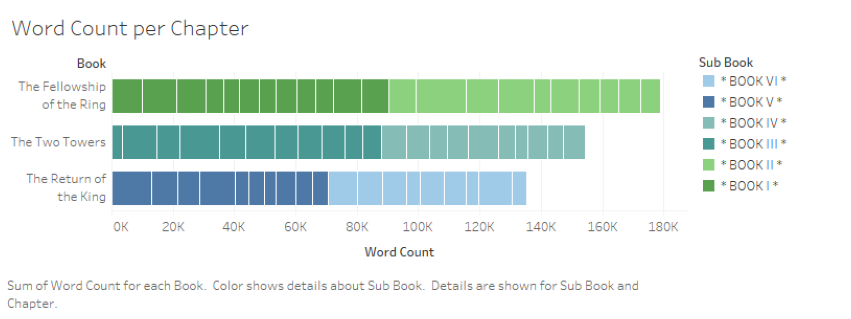

In [17]:
# Book Structure
plot_image('data/Word Count per Chapter.png')

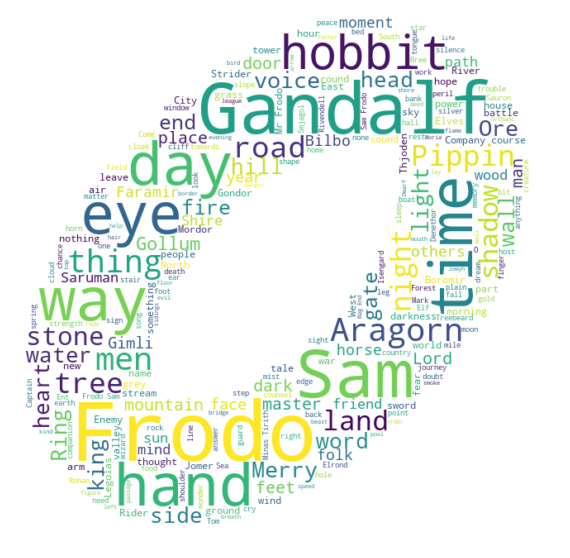

In [18]:
# Plot Wordcloud
fig=plt.figure(figsize=(10,10))
mask = np.array(Image.open('data/ring.png'))
wordcloud_text = ' '.join(chapters['nouns'])
wordcloud = WordCloud(background_color='white', mask=mask, width=mask.shape[1], height=mask.shape[0], 
                      max_words=500, max_font_size=100, min_font_size=7).generate(wordcloud_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

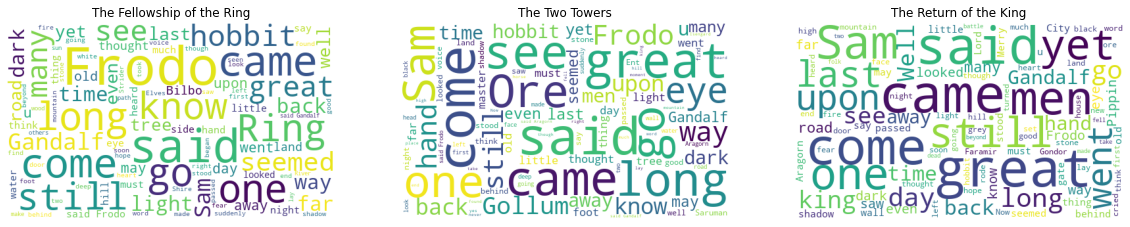

In [19]:
# Wordcloud per book
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = axs.ravel()

for i, book in enumerate(chapters['book'].unique()):
    # create wordcloud
    book_txt = ' '.join(chapters.loc[chapters['book'] == book, 'text_clean'])
    wordcloud = WordCloud(background_color='white', width=500, height=300, max_words=100, max_font_size=80).generate(book_txt)
    # plot wordcloud
    axs[i].imshow(wordcloud)
    axs[i].set_title(book)
    axs[i].axis('off')
plt.show()

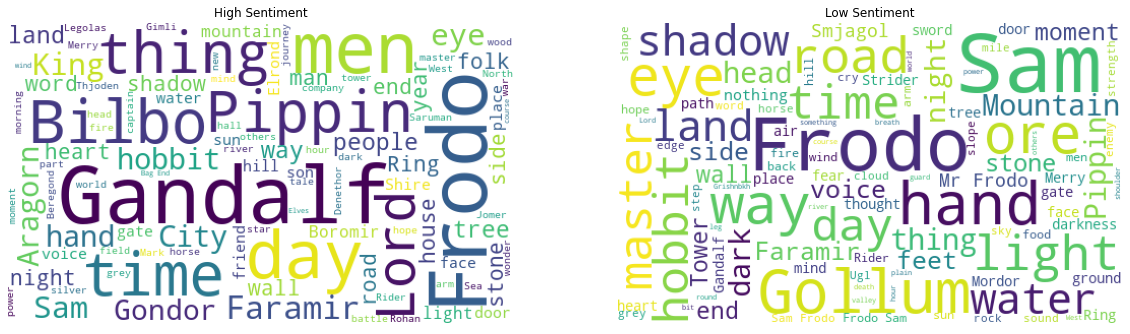

In [45]:
# Wordcloud per sentiment # TODO: split into sentences plot very pos/neg sentences (=more detailed than chapters)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs = axs.ravel()

# create wordcloud high sentiment
pos_txt = ' '.join(chapters.loc[chapters['sentiment_score_norm'] > 1, 'nouns'])
neg_txt = ' '.join(chapters.loc[chapters['sentiment_score_norm'] < -1, 'nouns'])
wordcloud_pos = WordCloud(background_color='white', width=500, height=300, max_words=100, max_font_size=80).generate(pos_txt)
wordcloud_neg = WordCloud(background_color='white', width=500, height=300, max_words=100, max_font_size=80).generate(neg_txt)
axs[0].imshow(wordcloud_pos)
axs[0].set_title('High Sentiment')
axs[0].axis('off')
axs[1].imshow(wordcloud_neg)
axs[1].set_title('Low Sentiment')
axs[1].axis('off')
plt.show()

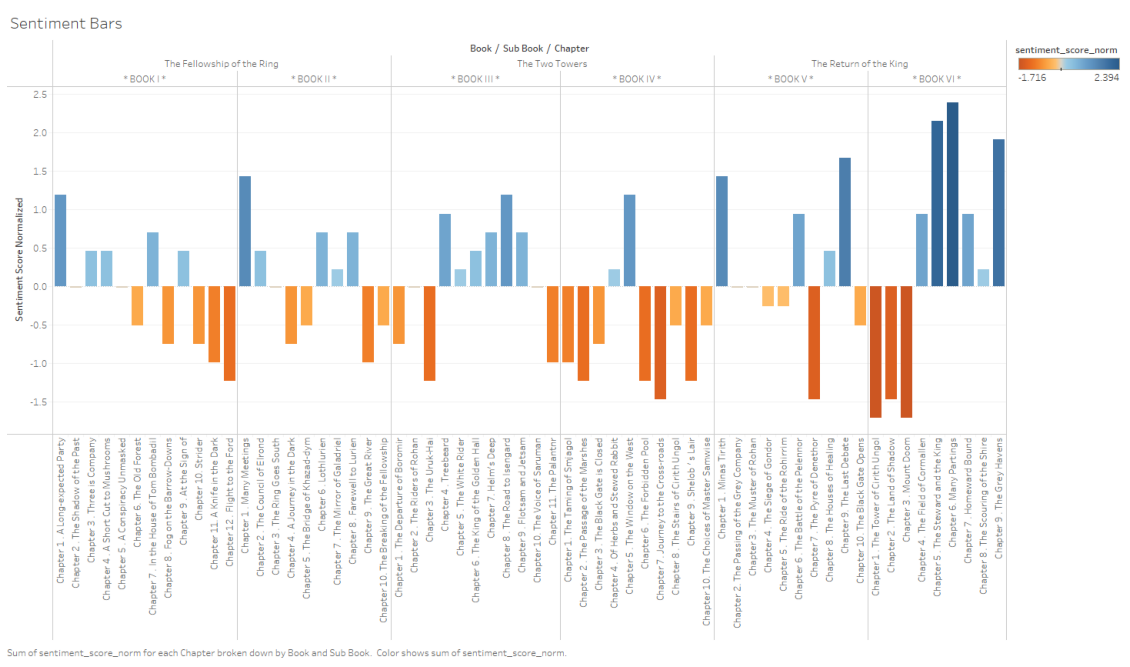

In [20]:
# Plot sentiment score per chapter
plot_image('data/Sentiment Bars.png', (20,20)) # 'data/Sentiment Bars Vertical.png'

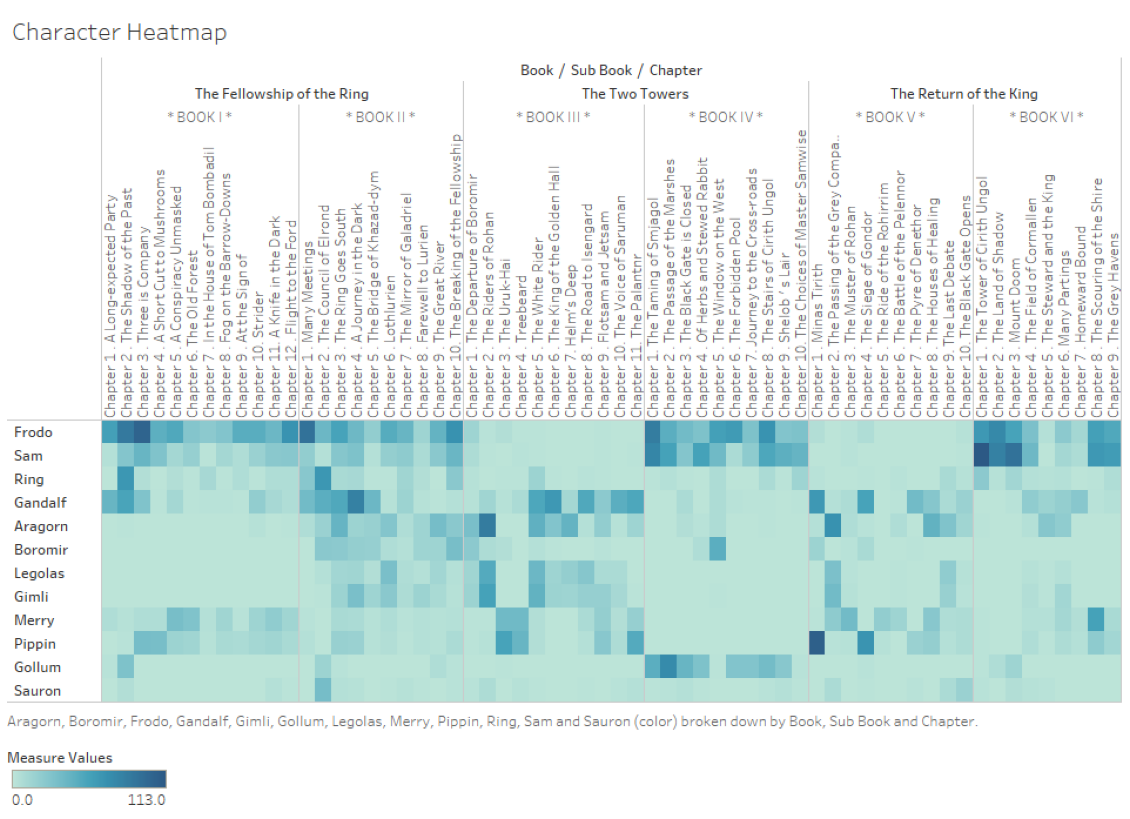

In [41]:
# Plot Character Count
plot_image('data/Character Heatmap.png', (20,20))

In [72]:
# Find most common Characters
chars['first_name'] = chars['name'].apply(lambda x: x.split(' ')[0])
chars['mentions_firstname'] = chars.apply(lambda x: chapters['text'].str.count(x['first_name']).sum(), axis=1)
chars['mentions_fullname'] = chars.apply(lambda x: chapters['text'].str.count(x['name']).sum(), axis=1)
important_chars = chars[(chars['mentions_fullname'] >= 2) & (chars['mentions_firstname'] > 10)]

# Manually remove characters
remove_list = ['in', 'The King of the Dead', 'mar', 'Men', 'Man in the Moon', 'Old Man Willow', 'Old Noakes', 'Will Whitfoot'] #"in (King of Durin's Folk)", 'The Moth', 'Frodo Gardner', 'Aragorn II Elessar', 
important_chars = important_chars[~important_chars['name'].isin(remove_list)]

important_chars = important_chars.append(chars[chars['name']=='Merry Gamgee']) # Add Merry

In [ ]:
# Network analysis of book charcters


In [21]:
### PLAN FOR ANALYSIS

# **** General overview of books ****
# Wordcloud of each movie ( + text cleaning as needed )

# **** Time series analysis ****
# Heatmap of when each character appears in book timeline (character mentions)
# Other keyword frequencies
# Sentiment time series + smoothing
# Sentiment analysis per chapter?

# **** Character / World ****
# Network analysis of characters (group X sentences together, check cooccurences )
# Degree of centrality ( connectedness of characters )

# Nr of new words introduced